In [1]:
import os
import json
import unicodedata
import re
import networkx as nx
import matplotlib.pyplot as plt
import tiktoken
from tqdm import tqdm
import time
from gradio_client import Client

In [2]:
client = Client("Qwen/Qwen2.5")

Loaded as API: https://qwen-qwen2-5.hf.space ✔


In [3]:
import PyPDF2

def read_pdf(filepath):
    """Читает PDF файл и возвращает текст.

    Args:
        filepath: Путь к PDF файлу.

    Returns:
        Строку, содержащую весь текст из PDF файла, или None, если произошла ошибка.
    """
    try:
        with open(filepath, 'rb') as f:
            pdf_reader = PyPDF2.PdfReader(f)
            text = ""
            for page in range(len(pdf_reader.pages)):
                page_obj = pdf_reader.pages[page]
                text += page_obj.extract_text()
            return text
    except FileNotFoundError:
        print(f"Ошибка: Файл '{filepath}' не найден.")
        return None
    except PyPDF2.errors.PdfReadError:
        print(f"Ошибка: Не удалось прочитать PDF файл '{filepath}'. Возможно, он поврежден.")
        return None
    except Exception as e:  # Общий обработчик ошибок для других непредвиденных ситуаций
        print(f"Ошибка при чтении PDF: {e}")
        return None

In [4]:
import requests
import json
import os

filepath = "Mephi_data.pdf"

text_input = read_pdf(filepath)

system_prompt = r"""
# Цель
Тебе на вход даётся текстовый документ. Сначала выдели все сущности, которые необходимы, чтобы передать всю содержащуются в тексте информацию и идеи. Далее, найди все связи между этими сущностями в тексте. Также найди связи между обнаруженными сущностями в тексте и контекстом - набор сущностей и связей, котоырй был извлечен в предыдущей итерации работы над другой частью этого текста.

{context}

# Шаги
1. Выдели все сущности. Для каждой найденной сущности, укажи:
- entity_name: Имя сущности, заглавными буквами
- entity_type: Предложи несколько категорий для сущности. Категории не должны быть конкретными, а должны быть наиболее общими. 
- entity_description: Подробное описание атрибутов сущности.
Не используй кавычки и другие знаки препинания в имени сущности. Удаляй лишние кавычки.
Выведи информацию о сущности в следующем виде (entity|<entity_name>|<entity_type>|<entity_description>)

2. Для всех сущностей, выделенных на шаге 1, выдели все связи, т.е. пары (исходная_сущность, целевая_сущность) которые *связаны* между собой.
Для каждой пары связанных сущностей, извлеки следующую информацию:
- source_entity: имя исходной сущности, как она найдена на шаге 1
- target_entity: имя целевой сущности, как она найдена на шаге 1
- relationship_name: короткое имя связи между сущностями
- relationship_description: описание того, как исходная сущность и целевая сущность связаны между собой. В связах могут участвовать только сущности, выделенные на шаге 1. 
 Выведи информацию о связях в следующем виде (relationship|<source_entity>|<target_entity>|<relationship_name>|<relationship_description>)

3. Выведи результат в виде списка, содержащего все сущности, найденные на шаге 1, и связи, найденные на шаге 2. Используй **перевод строки** как разделитель списка.

4. Когда закончишь, выведи [EOF]

######################
-Примеры-
######################
Текст:
Борщ — горячий заправочный суп на основе свёклы, которая придаёт ему характерный красный цвет.
В словаре В. И. Даля — род щей, похлёбка из квашеной свёклы, на говядине и свинине, или со свиным салом. Получило широкое распространение во многих национальных кухнях: это блюдо есть у русских, белорусов и др.
######################
Результат:
(entity|БОРЩ|БЛЮДО|горячий заправочный суп на основе свёклы)
(entity|ГОВЯДИНА|ИНГРЕДИЕНТ|Мясо коровы, входящее в состав борща)
(entity|СВИНИНА|ИНГРЕДИЕНТ|Мясо свиньи, входящее в состав борща)
(entity|ЩИ|БЛЮДО|вид первого блюда)
(entity|РУССКИЕ|НАРОД|проживающие в России)
(entity|БЕЛОРУСЫ|НАРОД|проживающие в Белоруссии)
(relationship|БОРЩ|ЩИ|ЧАСТНЫЙ_СЛУЧАЙ|Борщ является разновидностью Щей)
(relationship|БОРЩ|ГОВЯДИНА|СОДЕРЖИТ|Борщ может содержать говядину)
(relationship|БОРЩ|СВИНИНА|СОДЕРЖИТ|Борщ может содержать свинину)
(relationship|БОРЩ|РУССКИЕ|РАСПРОСТРАНЕНИЕ|Борщ распространён у русских)
(relationship|БОРЩ|БЕЛОРУСЫ|РАСПРОСТРАНЕНИЕ|Борщ распространён у белорусов)
[EOF]
######################
Текст:
Цифровой рубль  — цифровая валюта центрального банка, разрабатываемая Банком России (ЦБ РФ), третья форма российской национальной валюты в дополнение к уже существующим наличной и безналичной формам денег.
Цифровой рубль будет эмитироваться Банком России. Цифровой рубль сочетает в себе свойства наличных и безналичных рублей.
######################
Результат:
(entity|ЦИФРОВОЙ_РУБЛЬ|ВАЛЮТА|цифровая валюта центрального банка)
(entity|БАНК РОССИИ|БАНК|Центральный банк России)
(entity|НАЛИЧНАЯ|ФОРМА ДЕНЕГ|Деньги, распространяемые купюрами)
(entity|БЕЗНАЛИЧНАЯ|ФОРМА ДЕНЕГ|Деньги, распространяемые в электронном виде)
(relationship|ЦИФРОВОЙ РУБЛЬ|БАНК РОССИИ|ЭМИТИРУЕТСЯ|Цифровой рубль будет эмитироваться Банком России)
(relationship|ЦИФРОВОЙ РУБЛЬ|НАЛИЧНАЯ|ИМЕЕТ_СВОЙСТВА|Цифровой рубль имеет свойста наличных денег)
(relationship|ЦИФРОВОЙ РУБЛЬ|БЕЗНАЛИЧНАЯ|ИМЕЕТ_СВОЙСТВА|Цифровой рубль имеет свойста безналичных денег)
######################
-Реальные данные-
######################
Текст: {text}
######################
Результат:
"""

In [5]:
user_prompt = f'''Тебе на вход даётся текстовый документ {text_input}. Сначала выдели все сущности, которые необходимы, чтобы передать всю содержащуются в тексте информацию и идеи. Далее, найди все связи между этими сущностями в тексте.
 Также найди связи между обнаруженными сущностями в тексте и контекстом - набор сущностей и связей, котоырй был извлечен в предыдущей итерации работы над другой частью этого текста.
 Четко следуй системным инструкциям.'''

In [6]:
def process_text_qwen(system_prompt="", prompt = user_prompt): 
    try:
        result = client.predict(
            query=prompt,
            system=system_prompt,
            radio="72B",
            api_name="/model_chat"
        )
        response = result[1][0][-1]['text']          

        return response

    except Exception as e:
        print(f"Error with Qwen via Gradio: {e}")
        return None

In [7]:
def save_response_to_json(response: str, filename: str, output_dir: str):
    if response is None:
        print(f"Файл {filename} не будет сохранён ввиду пустого запроса.")
        return

    filepath = os.path.join(output_dir, filename)
    os.makedirs(output_dir, exist_ok=True)
    with open(filepath, "w", encoding="utf-8") as f:
        if "processed" in output_dir:
            json.dump(response, f, ensure_ascii=False, indent=4)
        else:
            json.dump({"model_response": response}, f, ensure_ascii=False, indent=4)

In [8]:
import unicodedata

ACCENT_MAPPING = {
    '́': '',
    '̀': '',
    'а́': 'а',
    'а̀': 'а',
    'е́': 'е',
    'ѐ': 'е',
    'и́': 'и',
    'ѝ': 'и',
    'о́': 'о',
    'о̀': 'о',
    'у́': 'у',
    'у̀': 'у',
    'ы́': 'ы',
    'ы̀': 'ы',
    'э́': 'э',
    'э̀': 'э',
    'ю́': 'ю',
    '̀ю': 'ю',
    'я́́': 'я',
    'я̀': 'я',
}
ACCENT_MAPPING = {unicodedata.normalize('NFKC', i): j for i, j in ACCENT_MAPPING.items()}


def unaccentify(s):
    source = unicodedata.normalize('NFKC', s)
    for old, new in ACCENT_MAPPING.items():
        source = source.replace(old, new)
    return source

def normalize(text):
    return (unaccentify(text)
            .replace('«','')
            .replace('»','')
            .replace('"','')
            .replace('<','')
            .replace('>',''))

In [9]:
import re

def add_entity(entities,name,kind,desc):
    if name in entities.keys():
        entities[name]['kind'].append(kind)
        entities[name]['desc'].append(desc)
    else:
        entities[name] = { 'kind' : [kind], 'desc' : [desc] }

def extract_ER(lines):
    entities = {}
    relations = []
    for x in lines:
        x = normalize(x)
        if z:=re.match(r'\((.*)\)',x):
            z = z.string.strip()[1:-1].split('|')
            z = [t.strip().lower() for t in z]
            if z[0] == 'entity':
                if len(z)<4:
                    z.append('')
                else:
                    add_entity(entities, z[1], z[2], z[3])
            elif z[0] == 'relationship':
                while len(z)<5:
                    z.append('')
                relations.append({ 
                    "source": z[1], 
                    "target" : z[2], 
                    "relation": z[3],
                    "desc" : z[4]})
            else:
                print(f'Неверная команда: {z}')
    relations = [x for x in relations if x['source'] in entities.keys() and x['target'] in entities.keys()]
    
    return entities, relations

In [10]:
import networkx as nx
import matplotlib.pyplot as plt


def plot_graph(G):
    plt.figure(figsize=(20,20))
    pos = nx.spring_layout(G)
    
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=12)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))
    
    plt.show()

def create_and_plot_graph(entities, relations, filename="graph.png", output_dir="graphs"):
    G = nx.DiGraph()
    exist_entities = set([r['source'] for r in relations] + [r['target'] for r in relations])

    for e, v in entities.items():
        if e in exist_entities:
            G.add_node(e, label=e)

    for r in relations:
        G.add_edge(r['source'], r['target'], label=r['relation'], desc=r['desc'])

    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=12)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))

    filepath = os.path.join(output_dir, filename)
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(filepath)
    plt.close()

In [11]:
import time

MAX_TOKENS = 1000
ENCODING = tiktoken.encoding_for_model("gpt-3.5-turbo")

def count_tokens(text):
    return len(ENCODING.encode(text))

def chunk_text(text, max_tokens=MAX_TOKENS):
    tokens = ENCODING.encode(text)
    chunks = []
    current_chunk = []

    for token in tokens:
        current_chunk.append(token)
        if len(ENCODING.decode(current_chunk)) >= max_tokens :
            chunks.append(ENCODING.decode(current_chunk[:-1]))
            current_chunk = [token]


    chunks.append(ENCODING.decode(current_chunk))
    return chunks

def format_context(entities, relations):
    context = "Ранее извлеченные сущности и связи:\n"
    if entities:
        context += "Entities:\n"
        for entity, data in entities.items():
            context += f"- {entity} (Types: {', '.join(data['kind'])})\n"
    if relations:
        context += "Relations:\n"
        for relation in relations:
            context += f"- {relation['source']} --{relation['relation']}--> {relation['target']}\n"
    return context

def process_text_with_context(text_chunks, prompt_template, system_prompt, context_cache=None, intermediate_filename="intermediate_results.json"):
    all_entities = {}
    all_relations = []

    if os.path.exists(intermediate_filename):
        with open(intermediate_filename, "r", encoding="utf-8") as f:
            intermediate_data = json.load(f)
            all_entities = intermediate_data["entities"]
            all_relations = intermediate_data["relations"]
            start_chunk_index = intermediate_data["last_processed_chunk"]
    else:
        start_chunk_index = 0

    for i in tqdm(range(start_chunk_index, len(text_chunks)), desc="Processing chunks", unit="chunk", initial=start_chunk_index, total=len(text_chunks)):
        chunk = text_chunks[i]

        if context_cache:
            cache_key = f"chunk_{i}"
            if cache_key in context_cache:
                context, entities, relations = context_cache[cache_key] 
                all_entities.update(entities)
                all_relations.extend(relations)
                continue

        if i > 0 and not context_cache:
            context = format_context(all_entities, all_relations)
        else:
            context = ""
            
        prompt = prompt_template.format(text=chunk, context=context)

        response = process_text_qwen(system_prompt, prompt) 
        if response:
            lines = response.strip().split('\n')
            entities, relations = extract_ER(lines)
            all_entities.update(entities)
            all_relations.extend(relations)

            if context_cache:
                context_cache[cache_key] = (context, entities, relations) 
        intermediate_data = {"entities": all_entities, "relations": all_relations, "last_processed_chunk": i + 1} 
        with open(intermediate_filename, "w", encoding="utf-8") as f:
            json.dump(intermediate_data, f, ensure_ascii=False, indent=4)

    return all_entities, all_relations


In [ ]:
def process_and_save_all(text: str, prompt_template: str, system_prompt: str,context_cache=None):
    raw_dir = "raw_responses"
    processed_dir = "processed_responses"
    graphs_dir = "graphs"

    text_chunks = chunk_text(text)

    entities, relations = process_text_with_context(
        text_chunks, prompt_template, system_prompt, context_cache=context_cache
    )

    response_text = "\n".join(f"(entity|{entity}|{', '.join(data['kind'])}|{'; '.join(data['desc'])})" for entity, data in entities.items()) + "\n" + "\n".join(f"(relation|{rel['source']}|{rel['target']}|{rel['relation']}|{rel['desc']})" for rel in relations)
    save_response_to_json(response_text, "qwen_response.json", raw_dir)

    processed_data = {"entities": entities, "relations": relations}
    save_response_to_json(processed_data, "qwen_processed_mephi.json", processed_dir) 

    create_and_plot_graph(entities, relations, filename="qwen_graph_mephi.png", output_dir=graphs_dir) 




cache = {}
process_and_save_all(text_input, system_prompt, user_prompt, context_cache=cache) 

Processing chunks:  59%|█████▉    | 10/17 [00:00<?, ?chunk/s]

In [12]:
with open('processed_responses/qwen_processed_mephi.json', "r", encoding="utf-8") as f:
    data = json.load(f)
    entities, relations = data["entities"], data["relations"]

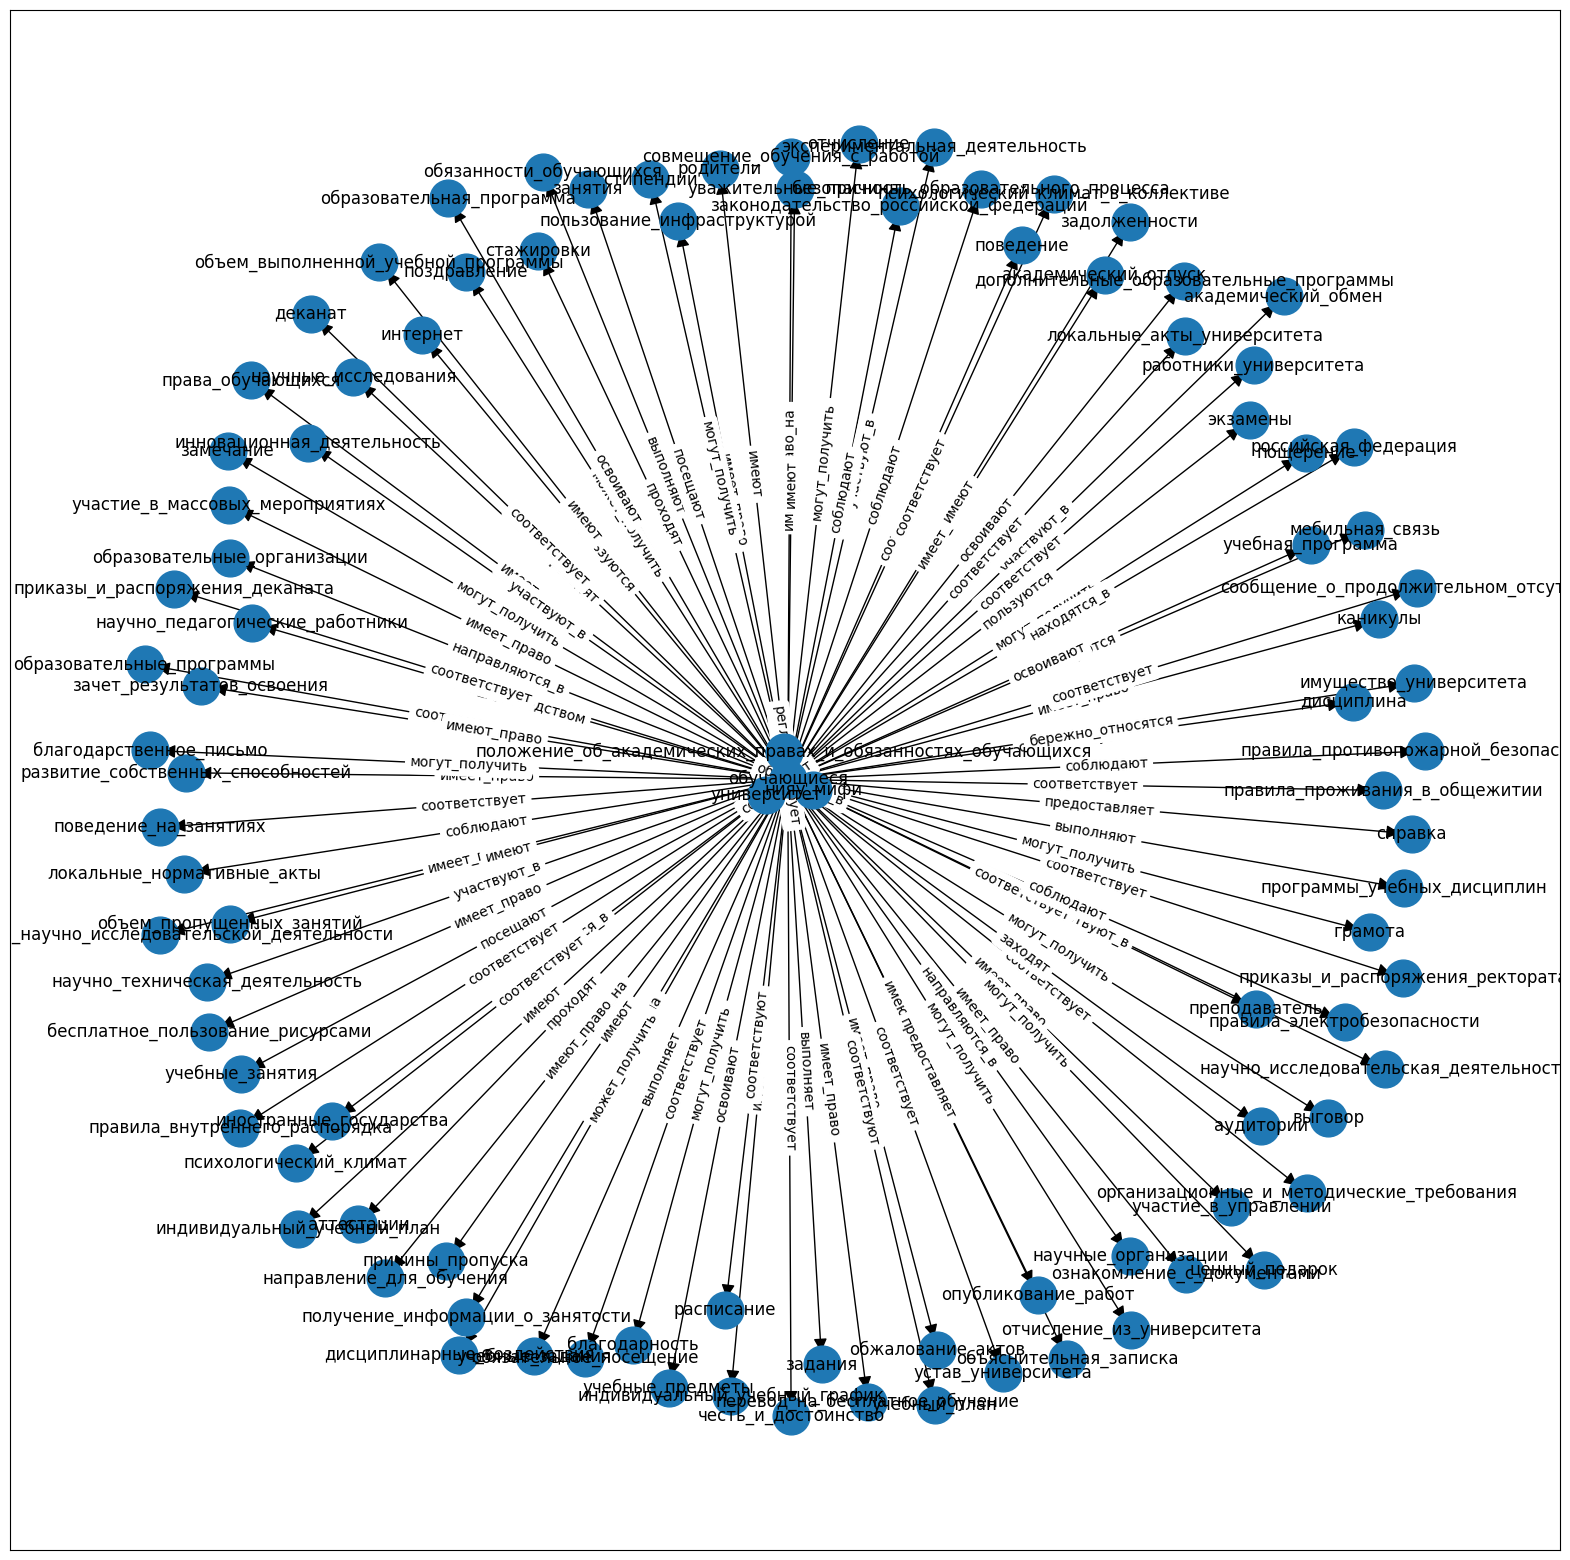

In [20]:
G = nx.DiGraph()

def populate_graph(G,e,level=None):
    if e in G.nodes:
        return
    if e in entities.keys():
        G.add_node(e, label=e)
    if level is not None and level<=0:
        return
    new_ent = set(
        [r['source'] for r in relations if r['target'] == e] + 
        [r['target'] for r in relations if r['source'] == e])
    for ne in new_ent:
        populate_graph(G,ne,None if level is None else level-1)
    for r in relations:
        if r['source'] == e:
            G.add_edge(e, r['target'], label=r['relation'], desc=r['desc'])
        if r['target'] == e:
            G.add_edge(r['source'], e, label=r['relation'], desc=r['desc'])
        
populate_graph(G,"обучающиеся",1)

plot_graph(G)

In [14]:
question_system_prompt = """
Ниже в тройных обратных кавычках приводится короткий текст. Тебе необходимо выделить из него все сущности,
похожие на сущности из списка в двойных кавычках: "{list}". Верни только список сущностей в скобках
через запятую, например: (Яндекс, компания, директор). Верни только те сущности, которые в явном виде
присутствуют в запросе. Не придумывай никакие дополнительные сущности и не рассуждай.
--текст--
```
{}
```
""".replace('{list}',', '.join(entities.keys()))

q = "какие есть обязанности обучающихся НИЯУ МИФИ?"


In [15]:
ents = process_text_qwen(system_prompt=question_system_prompt, prompt=q)
print(ents)

(обязанности_обучающихся, обучающиеся_нияу_мифи)


In [16]:
user_system_prompt = "Отвечай не придумывая ничего нового от себя. Четко следуй инструкциям основного запроса."

question_prompt ="""
Тебе задан следующий запрос от пользователя: {question}.
Ответь на этот вопрос, используя при этом информацию, содержащуюся ниже в тройных обратных кавычках:
```
{context}
```
"""

def create_context(G):
    return '\n'.join(
        e[-1]['desc'] for e in G.edges(data=True))

ans = process_text_qwen(system_prompt=user_system_prompt, prompt = question_prompt.replace('{context}',create_context(G)).replace('{question}',q))
print(ans)

Обучающиеся НИЯУ МИФИ имеют следующие обязанности:

1. Бережно относиться к имуществу университета.
2. Уважать честь и достоинство других обучающихся и работников университета.
3. Выполнять организационные и методические требования преподавателя.
4. Посещать все виды учебных занятий.
5. Вести себя так, чтобы не мешать другим и не отрицательно влиять на психологический климат в коллективе.
6. Выполнять все виды заданий в установленные сроки.
7. Сообщать о длительном отсутствии на занятиях.
8. Предоставлять справки и объяснительные записки в деканат в случае пропуска занятий.
9. Соблюдать локальные нормативные акты университета, правила внутреннего распорядка, правила проживания в общежитии, приказы и распоряжения ректората и деканата.
10. Соблюдать требования обеспечения безопасности образовательного процесса, правила электробезопасности и противопожарной безопасности.
11. Не пользоваться мобильной связью и интернетом во время занятий и экзаменов.
12. Соответствовать учебному плану и ут

In [ ]:
print (create_context(G))

сроки в гражданском праве могут устанавливаться иными правовыми актами
сроки в гражданском праве возникают в результате волеизъявления людей
сроки в гражданском праве могут устанавливаться договором
сроки в гражданском праве могут устанавливаться судом
сроки в гражданском праве могут устанавливаться законом
императивные сроки являются видом сроков в гражданском праве
исковая давность является примером императивных сроков
исковая давность является видом императивных сроков
исковая давность применяется судом только по заявлению сторон в споре
исковая давность является видом сроков в гражданском праве
определенные сроки являются видом сроков в гражданском праве
общие сроки являются видом сроков в гражданском праве
частные сроки являются видом сроков в гражданском праве
суд рассматривает иск
суд выносит решение по иску
неопределенные сроки являются видом сроков в гражданском праве
диспозитивные сроки являются видом сроков в гражданском праве


NameError: name 'nx' is not defined